# Benchmarking the scANVI fix

In [1]:
# !pip install --quiet scvi-colab
# from scvi_colab import install

# install()

In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scib_metrics.benchmark import Benchmarker

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version", scvi.__version__)

Seed set to 0


Last run with scvi-tools version 1.1.0


In [72]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
adata_path = os.path.join(save_dir.name, "lung_atlas.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539942",
)
adata

  0%|          | 0.00/972M [00:00<?, ?B/s]

/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [6]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)

/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [7]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
scvi_model.train(max_epochs=300)

I0000 00:00:1701222167.570943  722116 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/home/martinkim/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 300/300: 100%|██████████| 300/300 [05:12<00:00,  1.03s/it, v_num=1, train_loss_step=533, train_loss_epoch=553]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [05:12<00:00,  1.04s/it, v_num=1, train_loss_step=533, train_loss_epoch=553]


In [70]:
def plot_metrics(model: scvi.model.SCANVI):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=False)

    ax = axes[0]
    ax.plot(
        model.history["train_classification_loss"], label="train", color="darkgreen"
    )
    ax.plot(
        model.history["validation_classification_loss"],
        label="validation",
        color="firebrick",
    )
    ax.set_ylabel("Classification loss")
    ax.set_xlabel("Epoch")
    ax.legend()

    ax = axes[1]
    ax.plot(model.history["train_calibration_error"], label="train", color="darkgreen")
    ax.plot(
        model.history["validation_calibration_error"],
        label="validation",
        color="firebrick",
    )
    ax.set_ylabel("Calibration error")
    ax.set_xlabel("Epoch")
    ax.legend()

    ax = axes[2]
    ax.plot(model.history["train_accuracy"], label="train", color="darkgreen")
    ax.plot(model.history["validation_accuracy"], label="validation", color="firebrick")
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epoch")
    ax.legend()

    fig.tight_layout()


def plot_confusion_matrix(
    model: scvi.model.SCANVI,
    subset: str | None = None,
    prediction_key: str = "_prediction",
    labels_key: str = "cell_type",
):
    adata = model.adata
    adata.obs[prediction_key] = model.predict()

    if subset == "validation":
        adata = model.adata[model.validation_indices].copy()
    elif subset == "train":
        adata = model.adata[model.train_indices].copy()

    df = adata.obs.groupby([labels_key, prediction_key]).size().unstack(fill_value=0)
    conf_mat = df / df.sum(axis=1).values[:, np.newaxis]

    plt.figure(figsize=(7, 7))
    _ = plt.pcolor(conf_mat)
    _ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
    _ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xlabel("Predicted")
    plt.ylabel("Observed")


def plot_latent_mde(
    model: scvi.model.SCANVI,
    color: list | str | None = None,
    subset: str | None = None,
    latent_key: str = "_latent",
    mde_key: str = "_mde",
):
    adata = model.adata
    adata.obsm[latent_key] = model.get_latent_representation()

    if subset == "validation":
        adata = model.adata[model.validation_indices].copy()
    elif subset == "train":
        adata = model.adata[model.train_indices].copy()

    adata.obsm[mde_key] = scvi.model.utils.mde(adata.obsm[latent_key])
    sc.pl.embedding(adata, basis=mde_key, color=color, ncols=1, frameon=False)

In [9]:
model_no_fix = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
    classifier_parameters={"logits": False},
)

/home/martinkim/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [10]:
model_no_fix.train(max_epochs=100, n_samples_per_label=100, check_val_every_n_epoch=1)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [04:55<00:00,  3.00s/it, v_num=1, train_loss_step=656, train_loss_epoch=635]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [04:55<00:00,  2.95s/it, v_num=1, train_loss_step=656, train_loss_epoch=635]


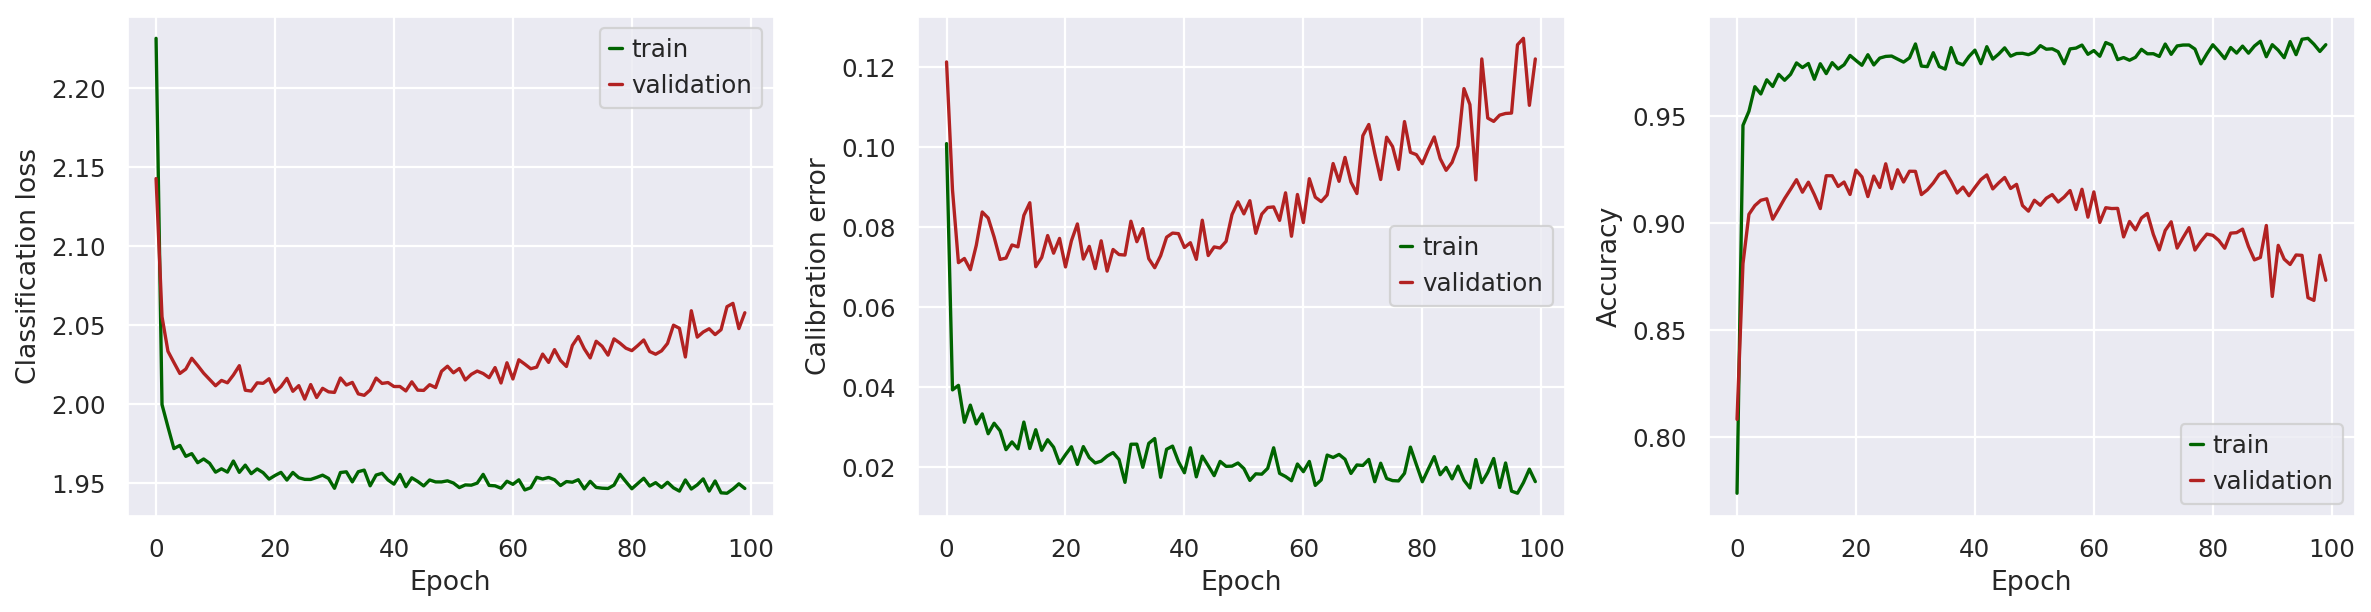

In [67]:
plot_metrics(model_no_fix)

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 480x480 with 0 Axes>

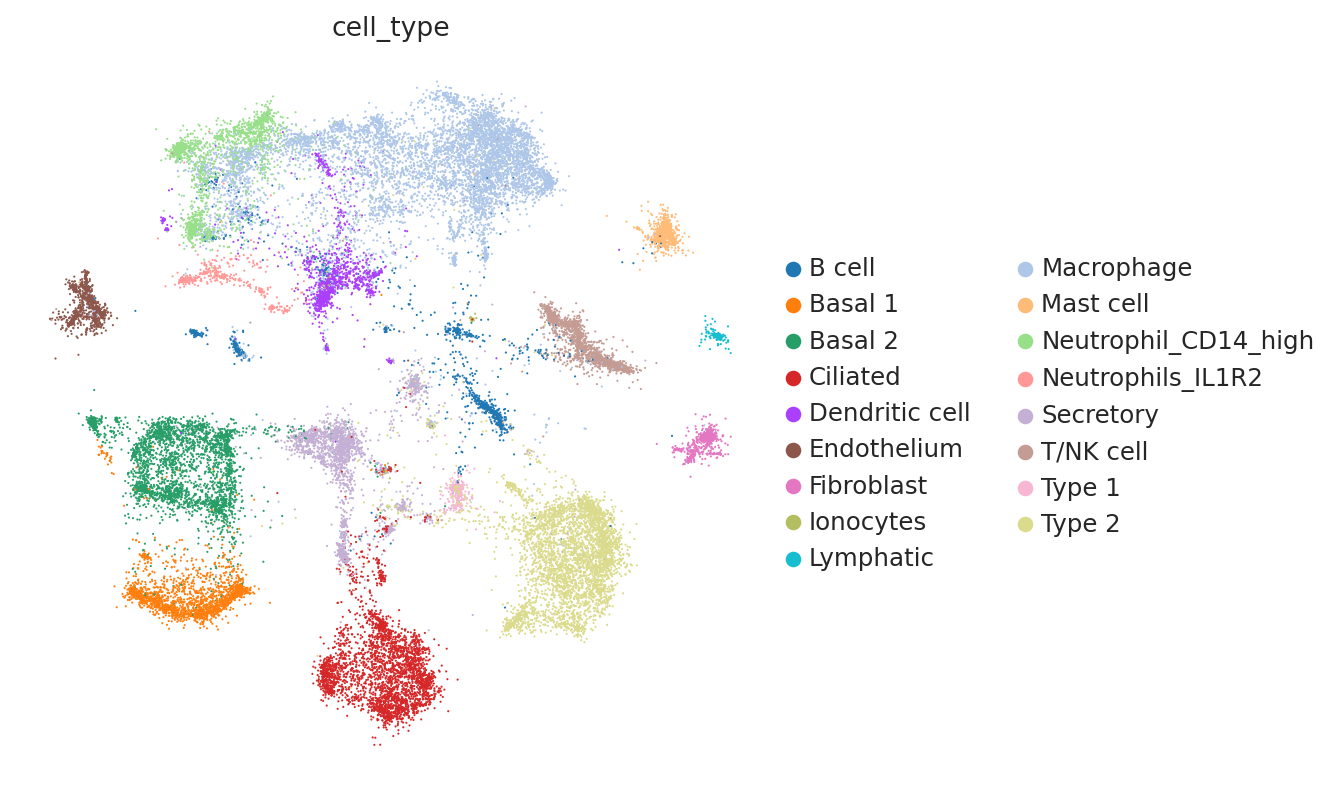

In [73]:
plot_latent_mde(model_no_fix, color="cell_type", latent_key="scanvi_no_fix")

/home/martinkim/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/tmp/ipykernel_722116/1529475643.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["cell_type", prediction_key])


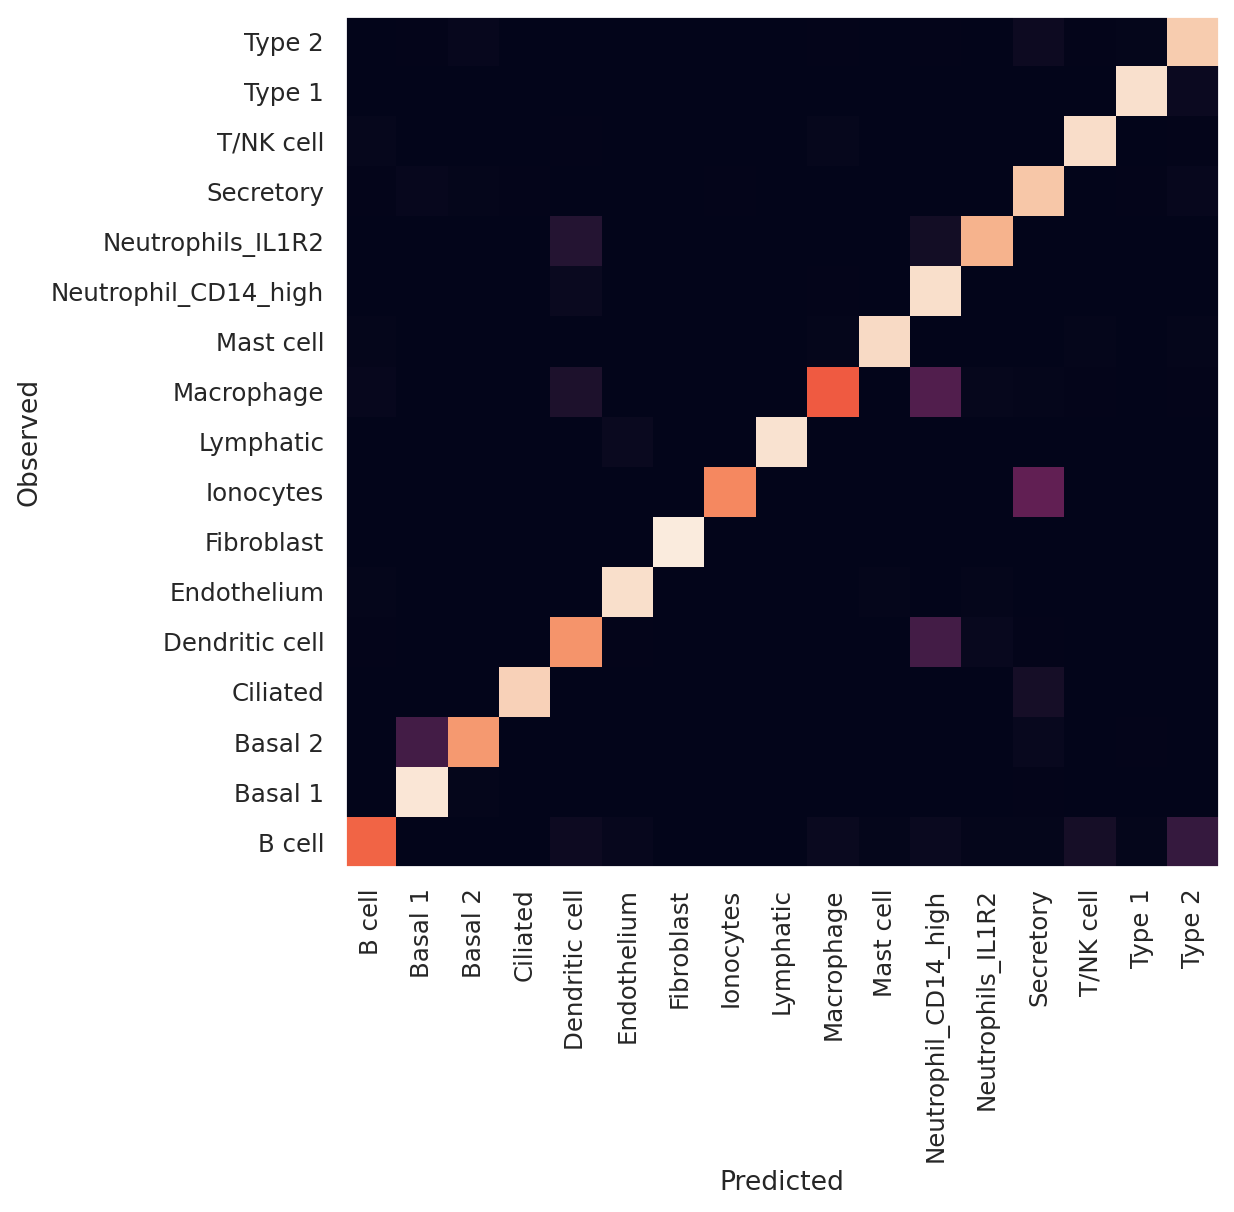

In [35]:
plot_confusion_matrix(model_no_fix, subset="validation")

In [14]:
model_fix = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

/home/martinkim/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [15]:
model_fix.train(max_epochs=100, n_samples_per_label=100, check_val_every_n_epoch=1)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [05:12<00:00,  3.13s/it, v_num=1, train_loss_step=609, train_loss_epoch=539]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [05:12<00:00,  3.12s/it, v_num=1, train_loss_step=609, train_loss_epoch=539]


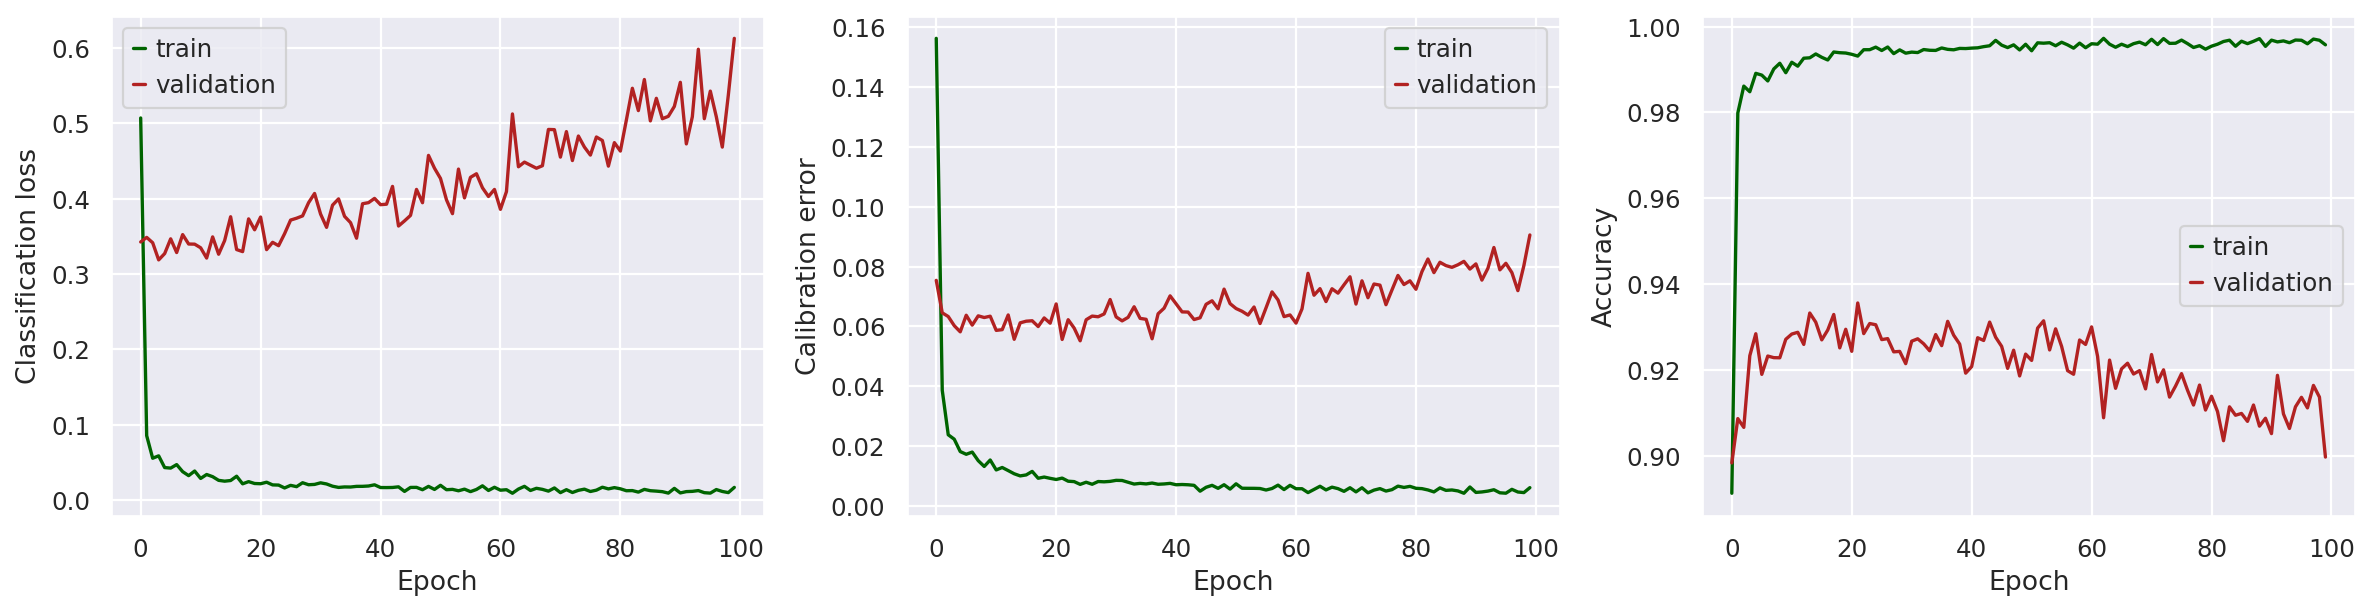

In [68]:
plot_metrics(model_fix)

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


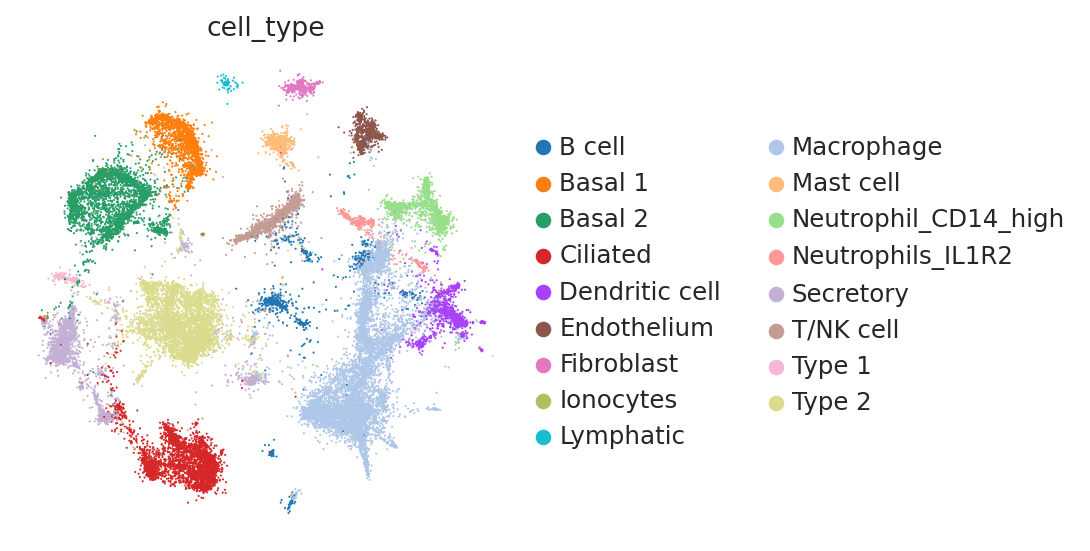

In [17]:
plot_latent_mde(model_fix, color="cell_type", latent_key="scanvi_fix")

/tmp/ipykernel_722116/3677293405.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["cell_type", prediction_key])


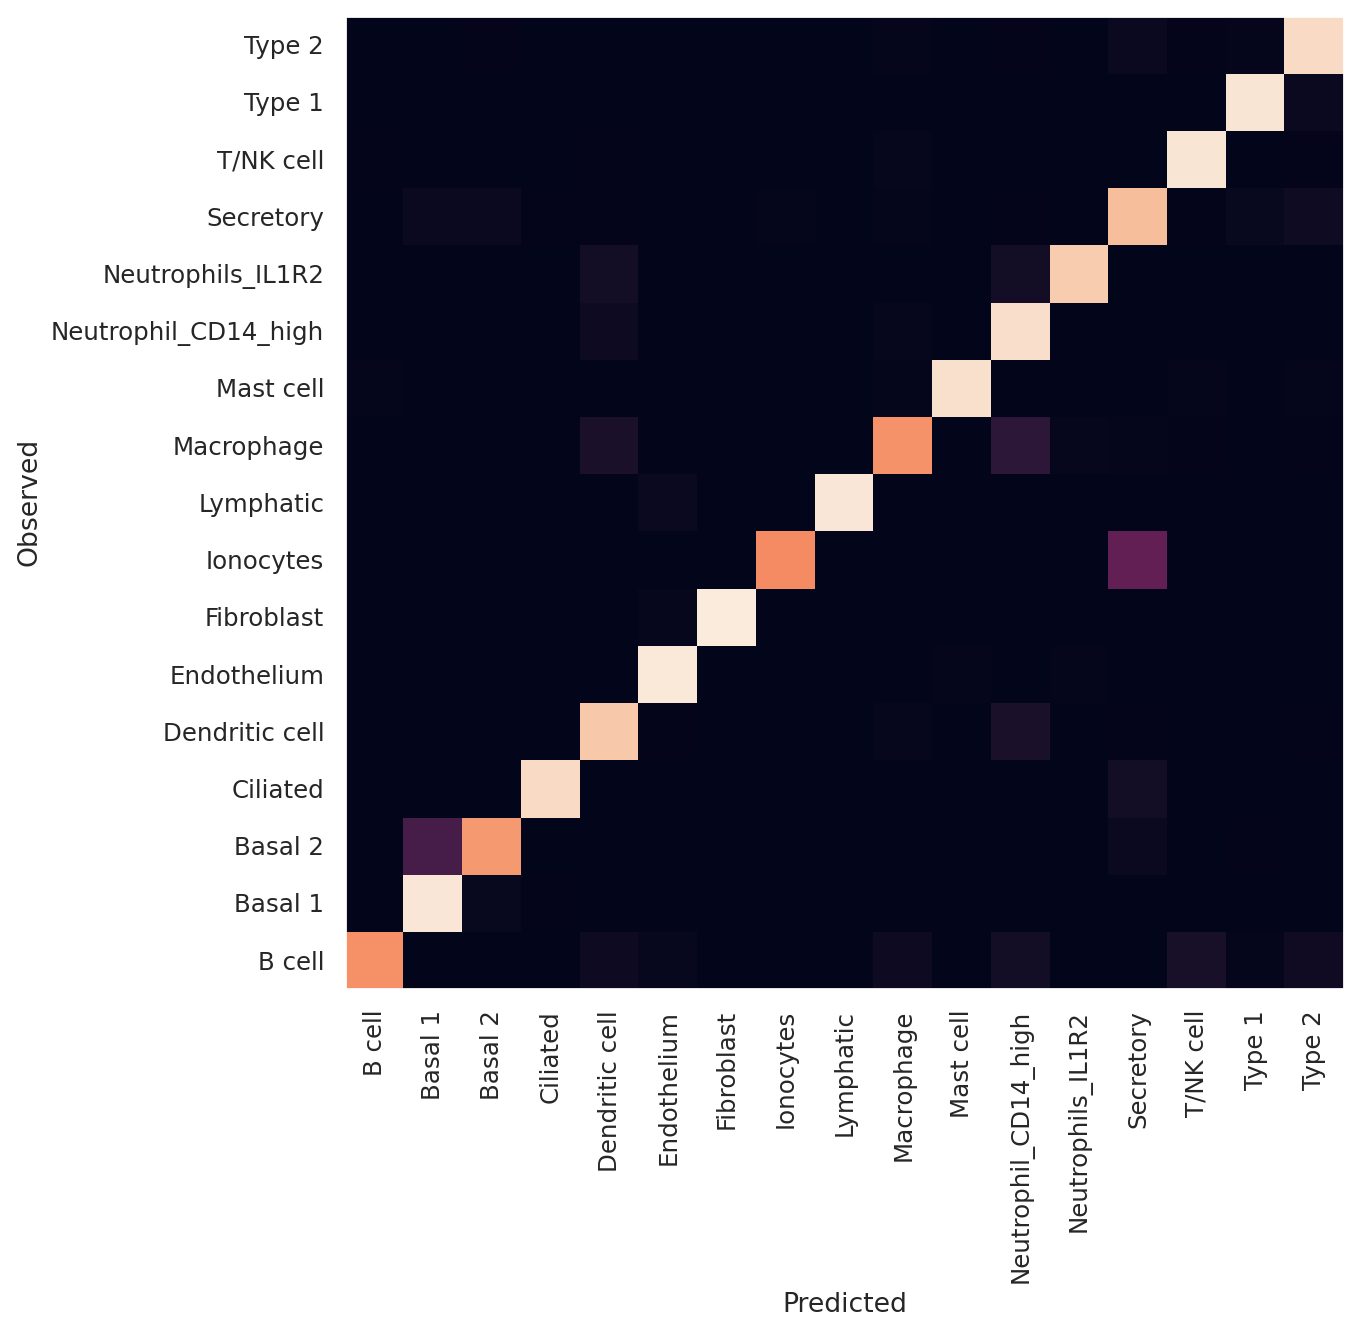

In [18]:
plot_confusion_matrix(model_fix, subset="validation")

In [19]:
model_fix_linear = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
    linear_classifier=True,
)

/home/martinkim/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [20]:
model_fix_linear.train(
    max_epochs=100, n_samples_per_label=100, check_val_every_n_epoch=1
)

INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [04:44<00:00,  2.76s/it, v_num=1, train_loss_step=533, train_loss_epoch=540]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [04:44<00:00,  2.85s/it, v_num=1, train_loss_step=533, train_loss_epoch=540]


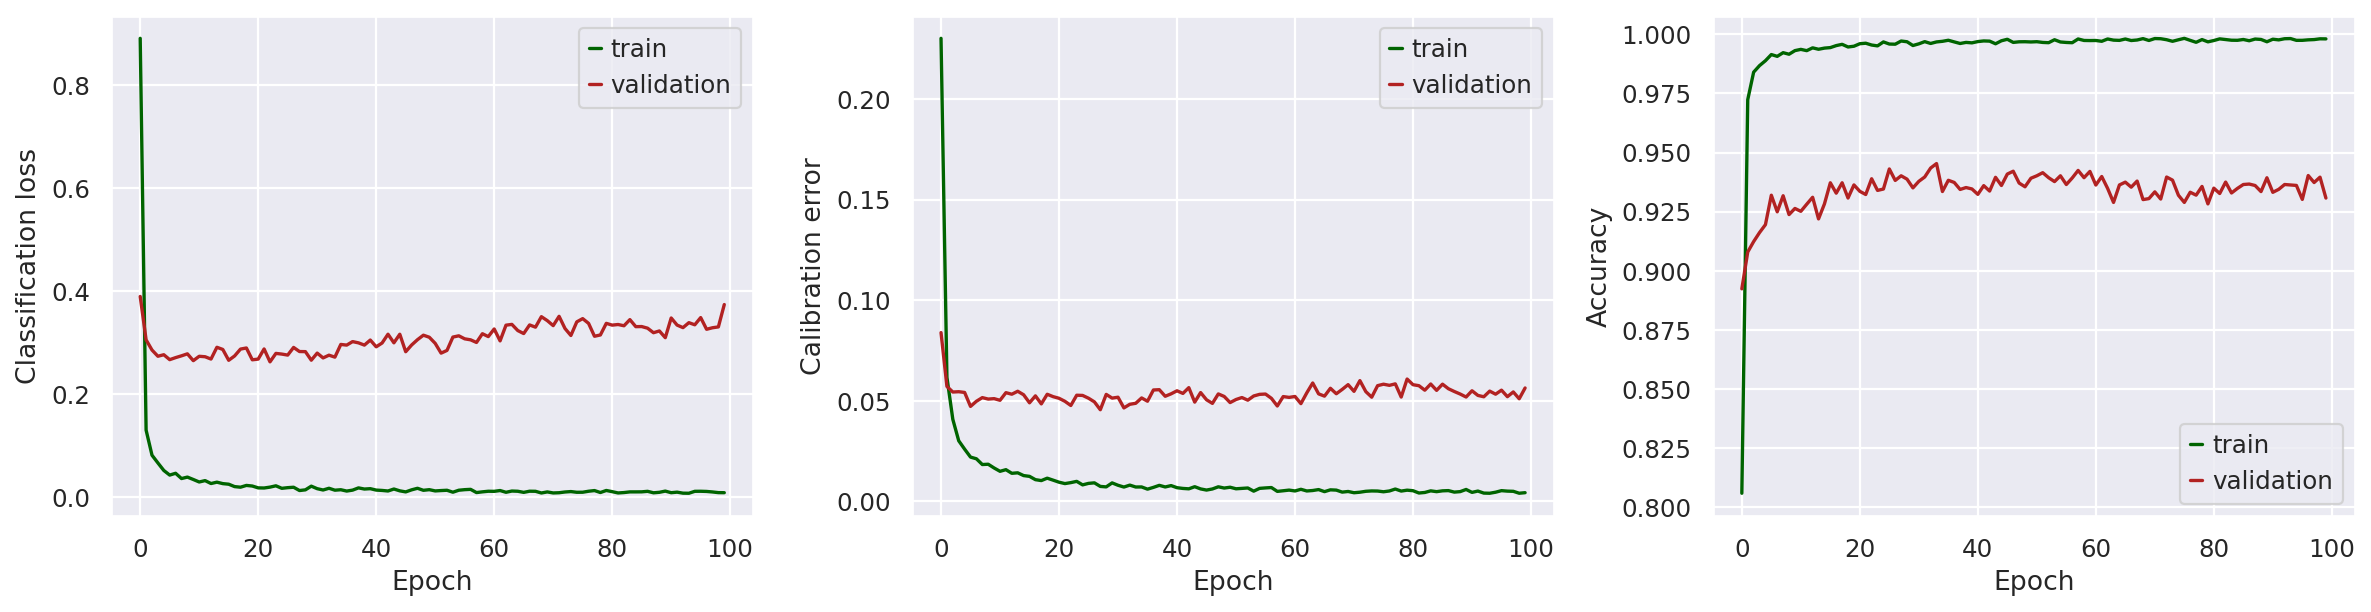

In [69]:
plot_metrics(model_fix_linear)

/home/martinkim/dev/scvi-tools/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 480x480 with 0 Axes>

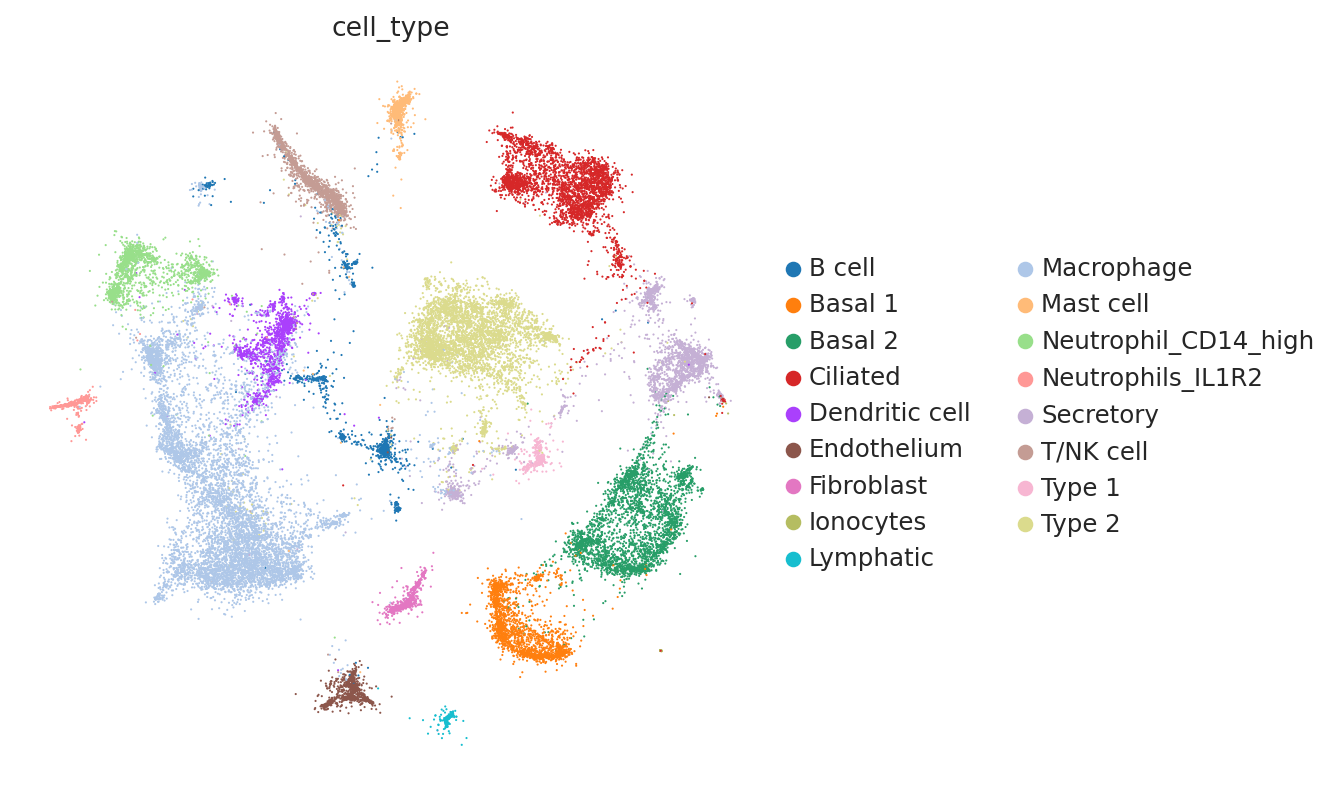

In [74]:
plot_latent_mde(model_fix_linear, color="cell_type", latent_key="scanvi_fix_linear")

/tmp/ipykernel_722116/3677293405.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(["cell_type", prediction_key])


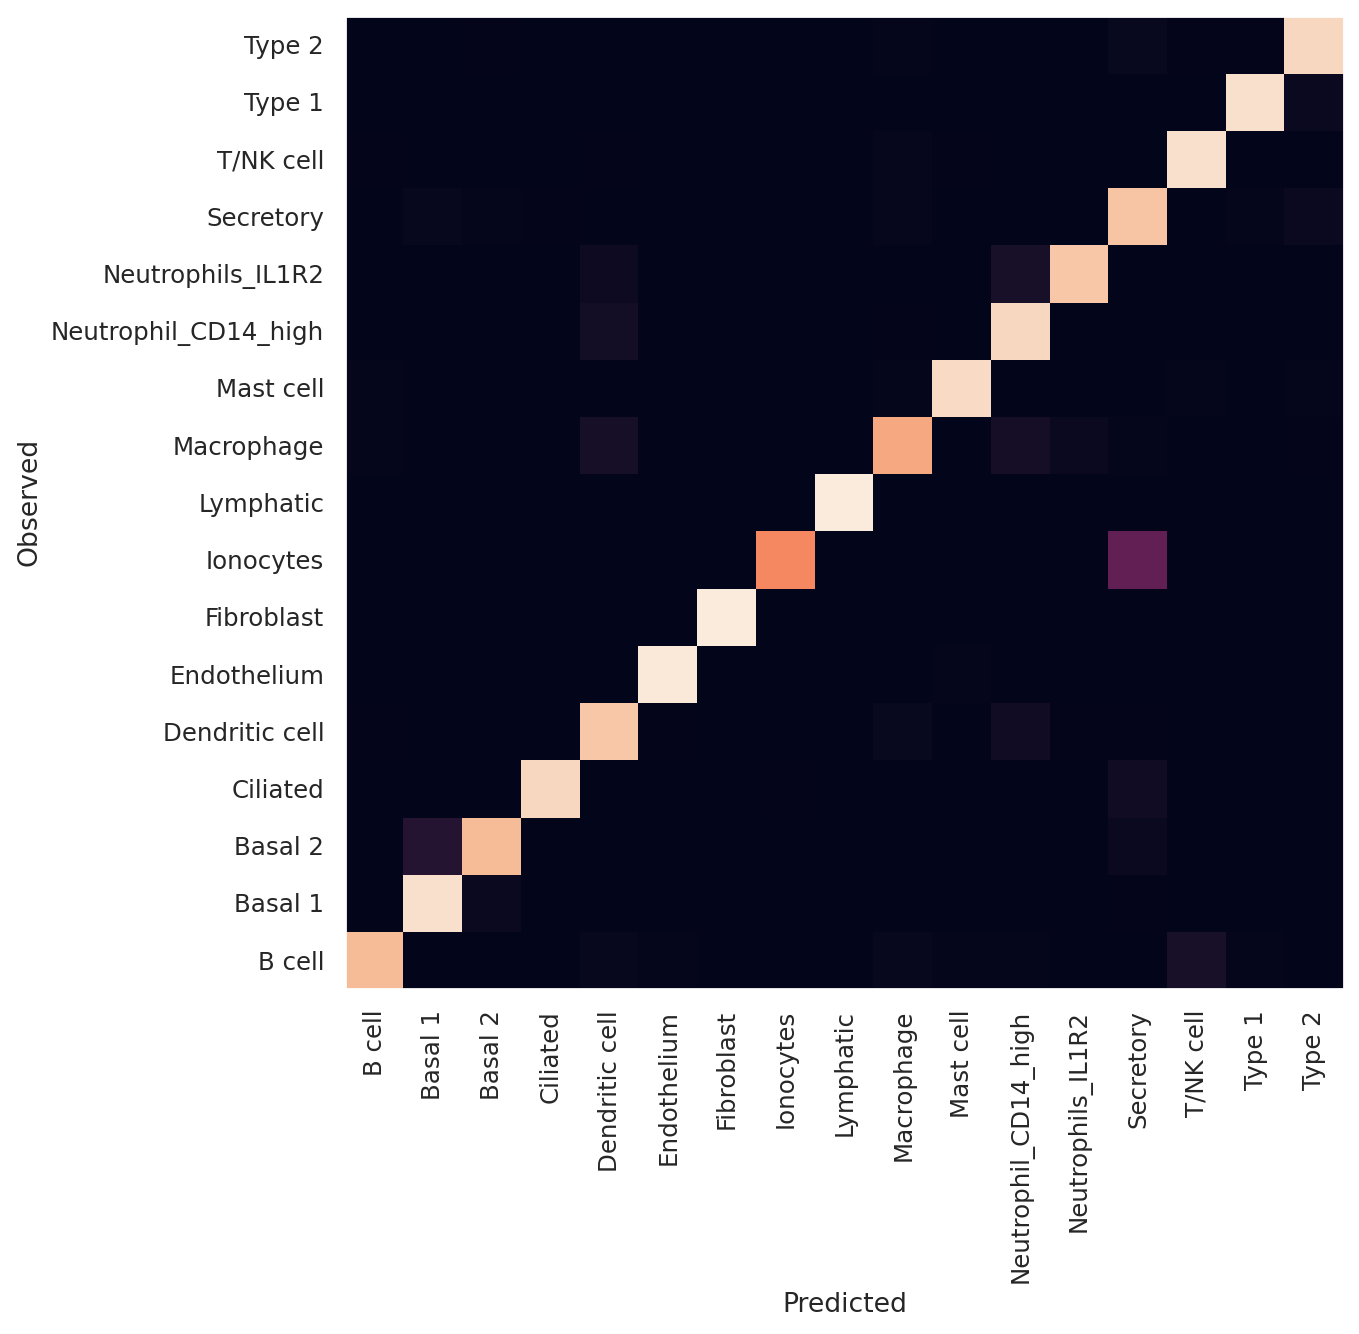

In [23]:
plot_confusion_matrix(model_fix_linear, subset="validation")

In [24]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", "scanvi_no_fix", "scanvi_fix", "scanvi_fix_linear"],
    n_jobs=-1,
)
bm.benchmark()

Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scib_metrics/_kbet.py:187: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scib_metrics/_kbet.py:187: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scib_metrics/_kbet.py:187: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/martinkim/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scib_metrics/_kbet.py:187: FutureWarning: p

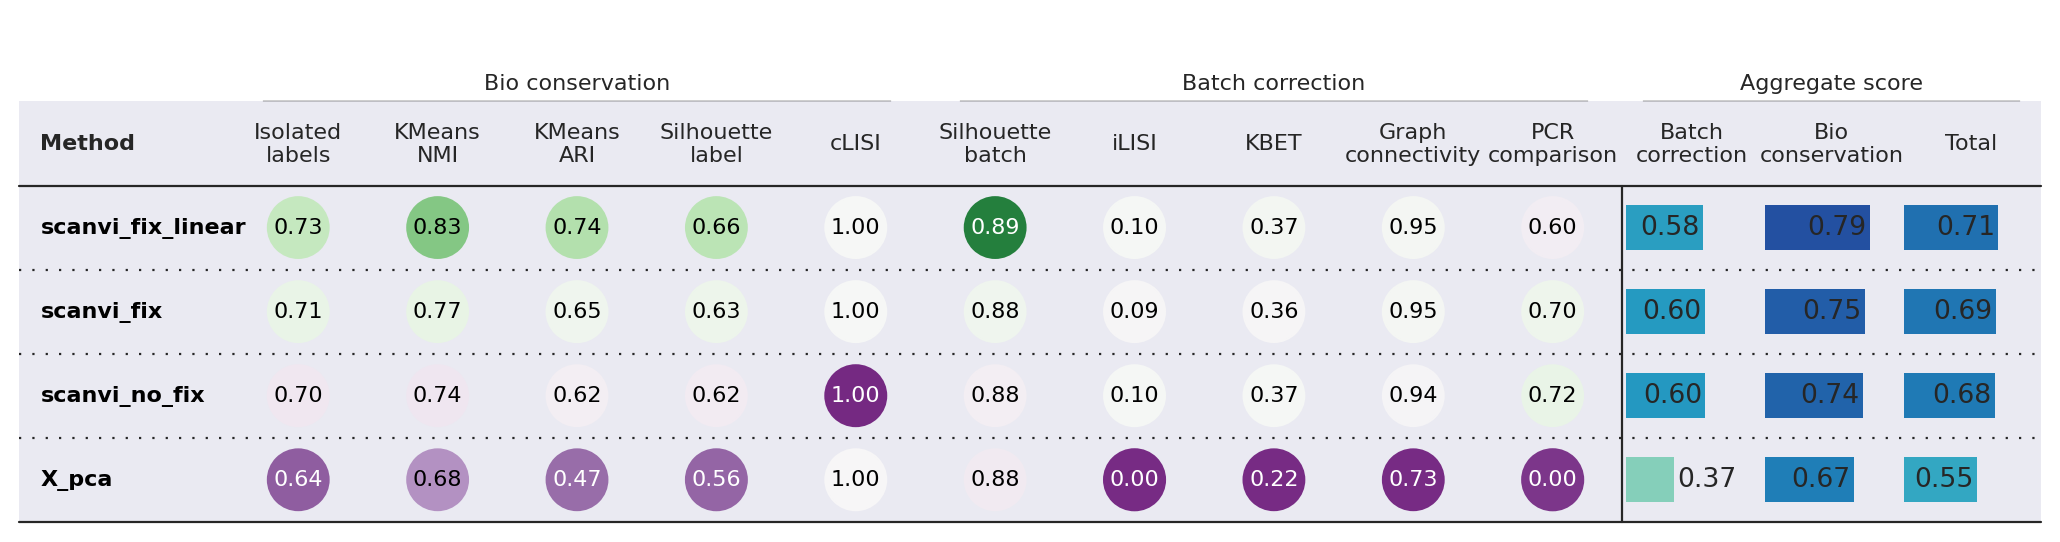

In [25]:
bm.plot_results_table(min_max_scale=False)